# 本篇是positional encoding篇

## 1. 在attention_is_all_you_need中, positional encoding是如何实施的. 

$$PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)=cos(pos/10000^{2i/d_{model}})}$$

每一个word的position信息会被encode为一个$d_model=512$维度的vector. 上面的余弦函数表示具体的encode规则.其中pos表示word的位置, i表示的是当前维度,其范围为0至$d_{model}/2$.
在提取到position信息之后,会将其与该word的具备同样维度大小的embedding特征进行直接的sum.从而得到包含position信息的综合feature.

"The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed. "

为了更好的理解,举一个具体的例子.以"attention is all you need"作为输入序列.不失一般性,这里将$d_{model}$调整小一点为4.那么就可以得到如下的positional encoding结果.

attention--->pos=0--->[sin(0/1),cos(0/1), sin(0/10000^{1/2}), cos(0/10000^{1/2})]--->[0, 1, 0, 1]

is--->pos=1--->[sin(1/1), cos(1/1), sin(1/10000^{1/2}), cos(1/10000^{1/2})]--->[0.017, 0.999, 0.000, 1.000]


## 2. 在attention_is_all_you_need中,positional encoding为什么要使用余弦函数.

对于为什么使用余弦函数,论文中给除了作者的原因.
We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PEpos+k can be represented as a linear function of PE pos.
这句话的重点在于相对position. 假如$PE_{(pos+k)}=A*PE_{pos}$.如果可以写成这种形式,就可以说两者可以表示为线性关系.
首先引用网上关于这一点的证明,证明采用sin, cos结合的encoding方式可以做到这一点.接着再回过头来强调这一点的重要性.
证明源自国外的一位博主,这里就直接贴图了.https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
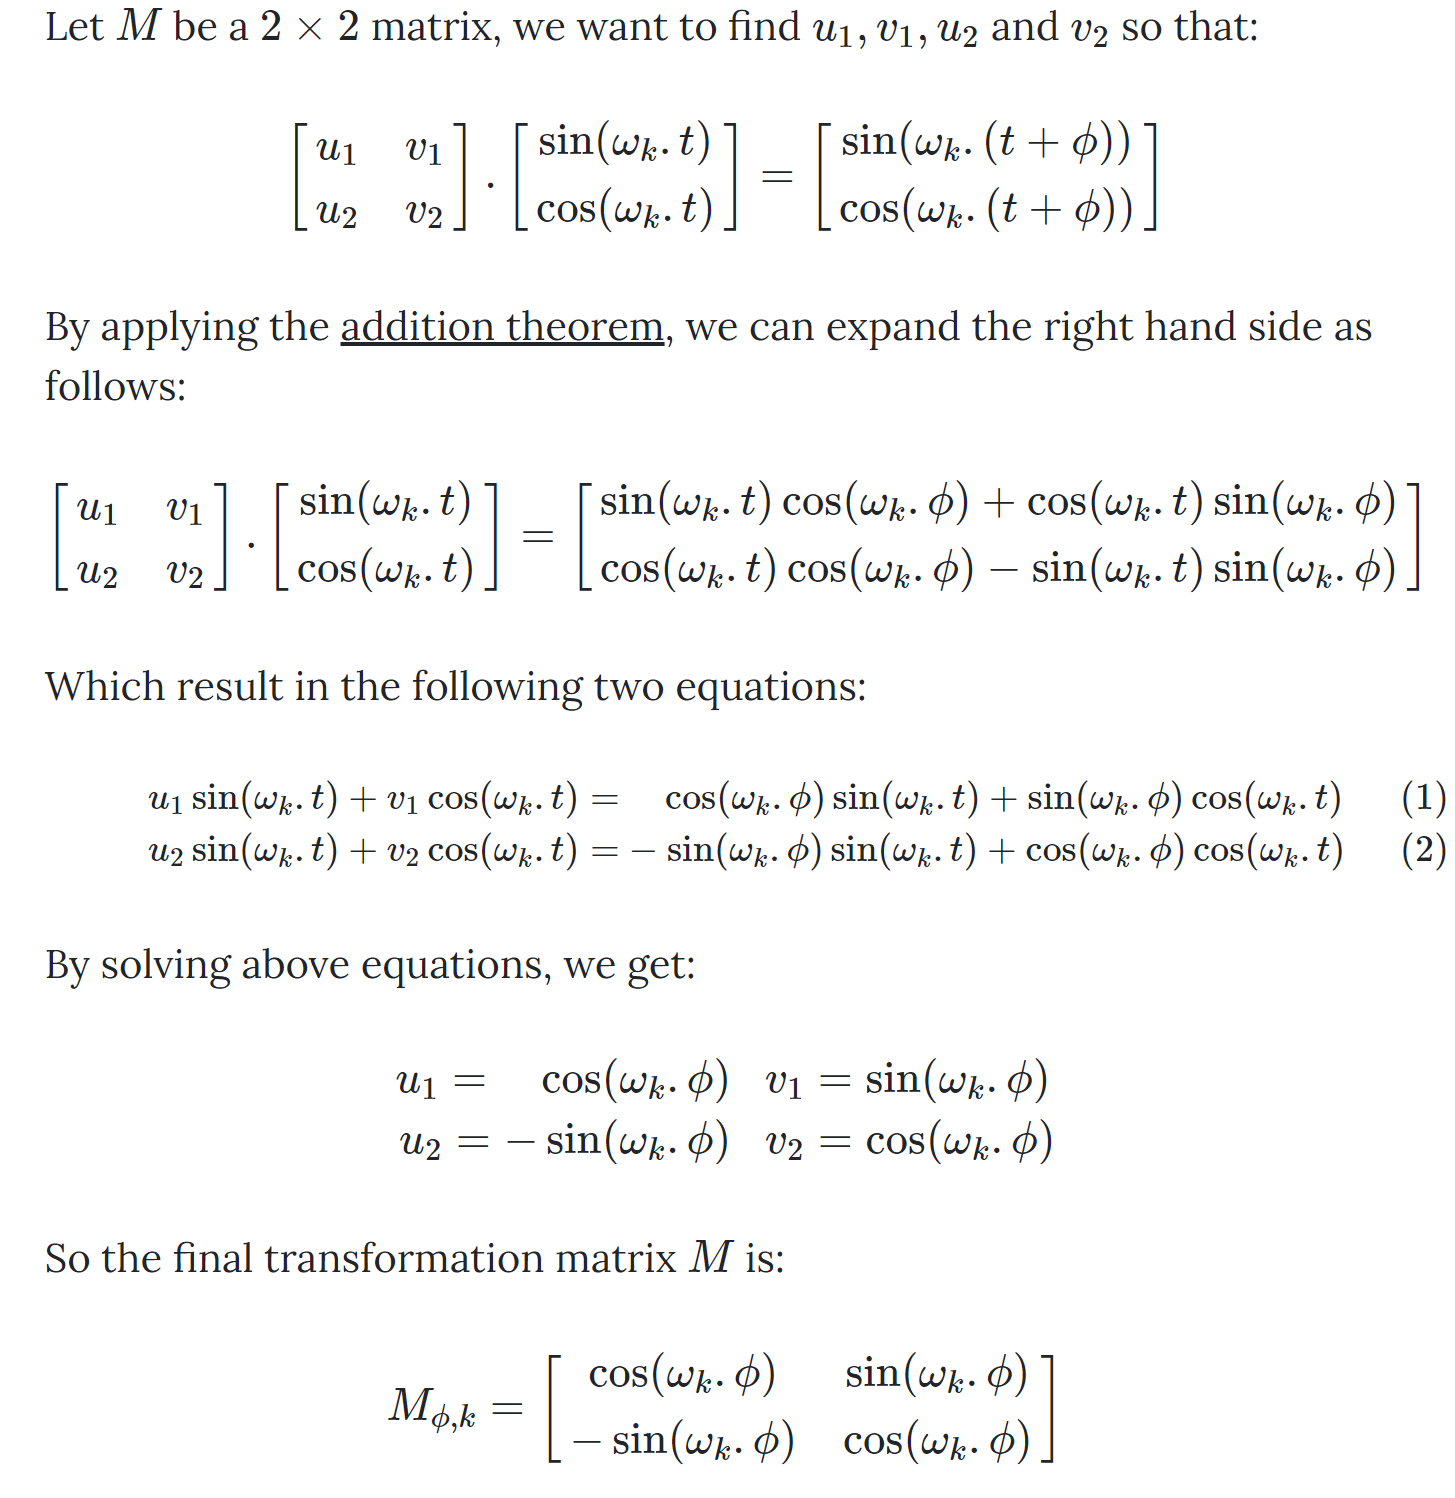


可以看到确实可以做这样的线性表示.matrix中仅仅和position的偏移量相关和当前positon无关.这一点很重要,因为直观上,我们也希望attention 与you的
positional encoding 偏移量与is和need的距离一致.


接下来再来讲一讲论文中没有提到,自己感觉需要稍微强调的点:
1. 使用sin和cos除了上述的理论好处外, 另外一个好处是,它的变化范围在[-1, 1]之间,这个和sigmoid有点像,数值上是一个比较合适的范围.
2. 为什么要使用不同的波长. 感觉这个是因为不太好确定那种波长是一个比较好的范围.或者说一个word之间的position差异,他们之间的编码范围应该多大合适呢? 如果暂时无法取得一个比较完美的理论值,那么使用一种渐变,综合的encode方式不失为一种好的方式.如果使用波长为2pi,那么一个词的position变化可能会显得过于强烈;如果使用波长为２pi*100000,则一个词语的变化则又显得无关痛痒.

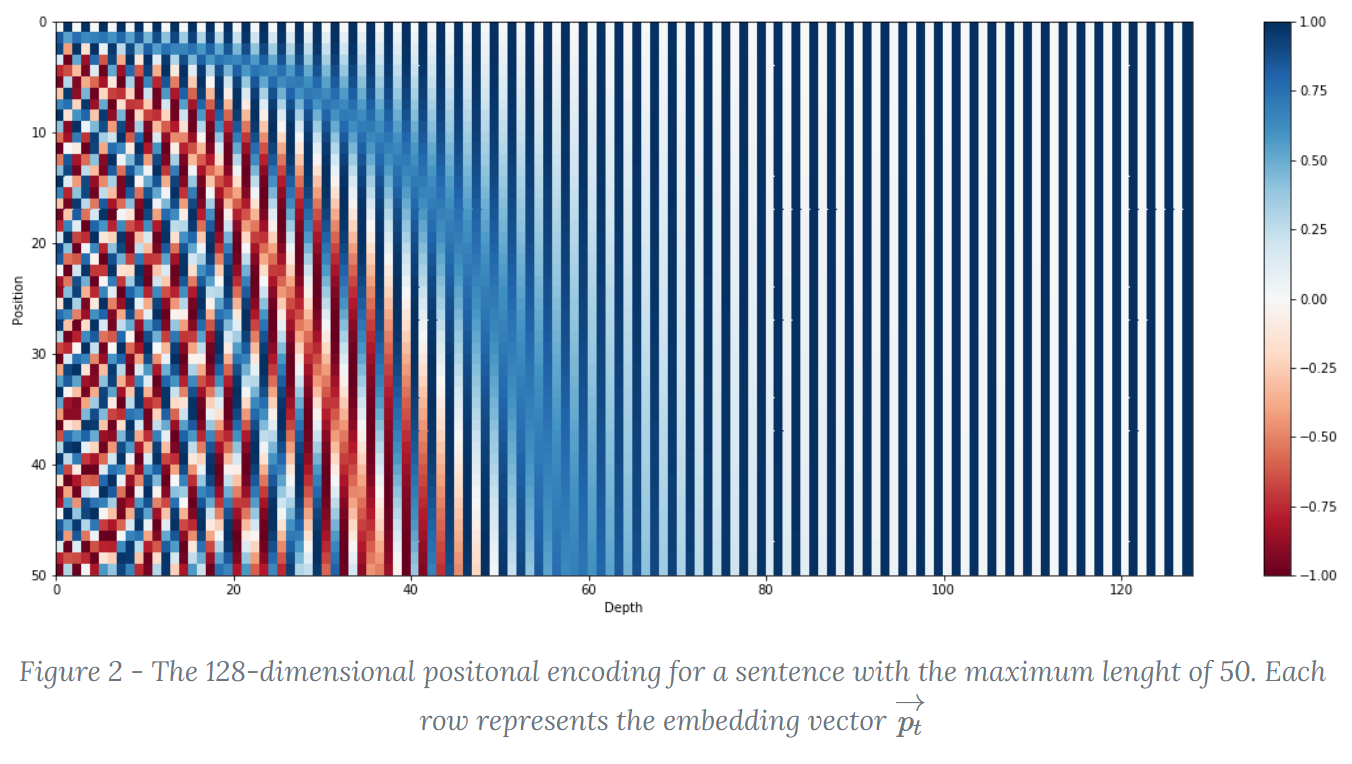

# 思考positional和word信息的融合, 是不是可以用到多模态重的问题.

参考资料:
[1]https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
[2]https://zhuanlan.zhihu.com/p/338592312

# attention is all you need 名字的原因
   在之前的sequence transduction模型中, 一般都是cnn和rnn占据主导地位. 最好的sequence transduction模型是在此基础上通过attention 机制将encoder和decoder连接起来. 作者实施了一种仅仅含有attention的新的网络结构称之为transormer(变形金刚).针对机器翻译任务,transoformer无论是指标还是并行度\训练时间都有优势.因此之所以称之为attention is all you need.在于transformer抛弃了cnn和rnn结构. 

#  RNN是如何做的？这样做有什么缺陷？

$h_t = f(h_{t-1}, t)$, t 表示position.
序列计算不具有并行性。factorization tricks和conditional computation可以一定程度上提升计算效率，但没有从本质上解决并行性的问题。
记忆很短。attention可以解决这一问题。
但之前都是针对并行性进行小的改善，针对记忆短进行了彻底的优化，使用attention。而这篇文章就是，摒弃这种序列关系，attention一把梭。

# 减少序列计算不就得了？
既然dependencies问题已经被attention解决了。那么序列问题就没有人尝试去根本解决吗？
* the Extended Neural GPU
* ByteNet
* ConvS2S


# self-attention是什么？ 而auto-regression又是什么？
现在还无法回答。关于self-attention建议在问答社区上问一问，关于auto-regression建议阅读如下文章。
Alex Graves. Generating sequences with recurrent neural networks. arXiv preprint arXiv:1308.0850, 2013。它的大概含义是：consuming the previously generated symbols as additional input when generating the next.

# transformer的大概结构
<div>
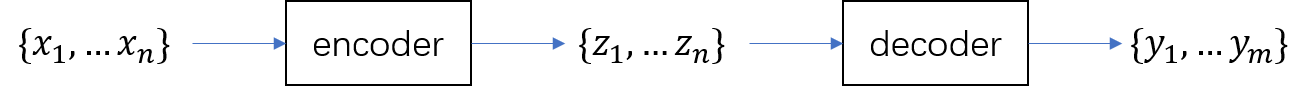
</div>
这边特别注意的是encoder之后，维度与encoder之前相同。但decoder之后，维度与输入的维度不一定相同。

## encoder结构是什么？
首先encoder是由N=6个相同的层堆砌而成。每一个层含有两个sub-layer。第一个sub-layer是multi-head self-attention layer; 第二个是一个简单的position-wise fully connected feed-forward network.每一个sub-layer都含有一个residual connection和一个layer norm层。所有的sub-layer的输出和embedding layer的输出的维度称之为$d_{model}=512$
<div>
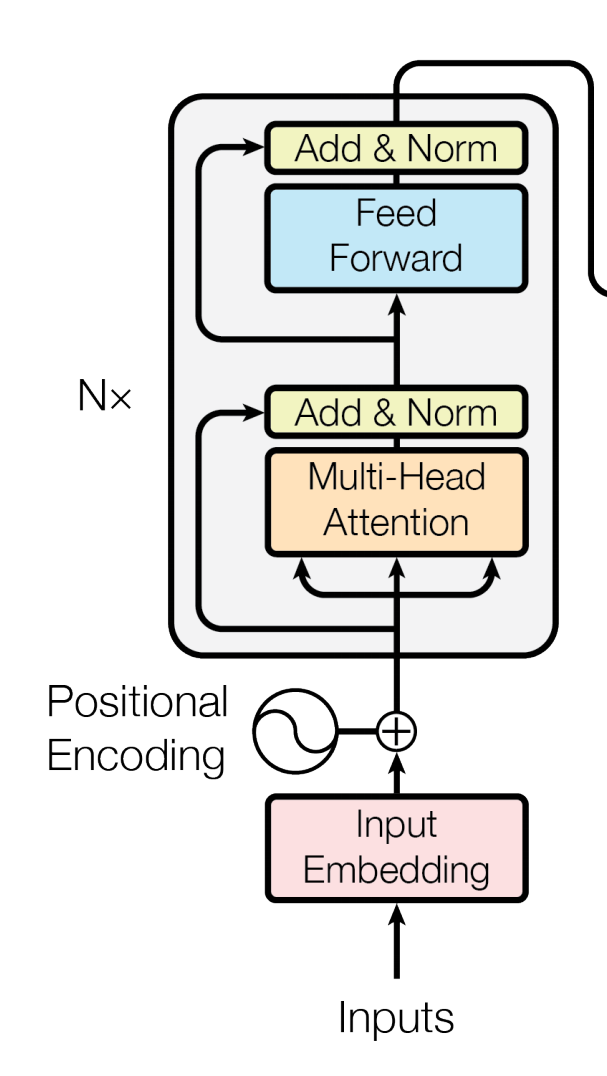
</div>

## decoder结果是什么
decoder也是有N=6个相同的层对堆砌而成。唯一的差距在于增加了一个masked multi-head attention. 该attention和 output embeddings相融合，一次移动一个position，确保在预测position i的输出时,仅仅依赖position i之前的output。
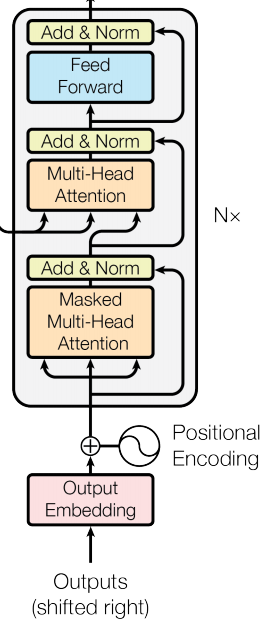

## 1. attention
attention是什么：一个attention function可以 被描述为映射一个query vector和一个key-value vector对到一个输出vector。输出可以看做是values的weighted sum. 而每一个value的weight是通过query和对应的key通过一个叫做调和函数（compatibility function)获得的。具体到本文所使用的调和函数为一个点乘操作，因此也叫做scaled dot-product attention.
<div>
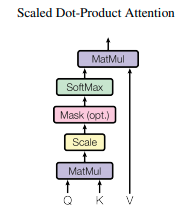
</div>

而论文中提到的multi-head attention是指，q, k ,v经过一个可学习的线性映射操作再送入到attention中。可学习的线性映射操作可以有h个。因此称之为multi-head attention.

<div>
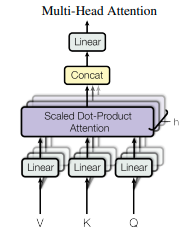
</div>

## 2. feed-forward fully connected network
这个操作事实上就是CNN中的全连接层，之所以强调feed-forward是因为相对于rnn来讲的。
FFN(x) = max(0, xW1 + b1)W2 + b

## 3. 不同操作之间的复杂度比较
<div>
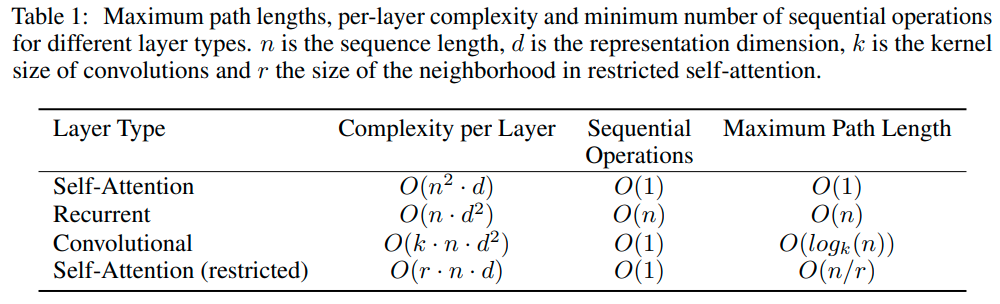
</div>

## 4. 训练
训练集使用的是WMT2014 英德和英法数据集。
p100 12h和3.5天。
使用的正则化手段包含：
1. dropout
2. label smooth
评价指标：BLEU